In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [13]:
def pdf(x_i, sigma_i=1):
    """Returns the pdf of X_i ~ Normal(0, sigma_i^2). Assumes mean of 0."""
    return st.norm.pdf(x_i, scale=sigma_i)

#### Conditional descendant distribution
$$X_{i+n}|X_i \sim \mathcal{N}( \tilde{\mu}_{i+n}, \tilde{\sigma}_{i+n}^2)$$

$$\tilde{\mu}_{i+n} = r^nX_i$$

$$\tilde{\sigma}_{i+n}^2 = [(r^2+r_s^2)^n-r^{2n}] \sigma_i^2$$

In [14]:
def mu_tilda(x_i, r, n):
    return (r**n)*x_i


def sigma_tilda(sigma_i, r, rs, n):
    return sigma_i * np.sqrt(
            (np.square(r)+np.square(rs))**n - r**(2*n))

# test sigma_tilda
assert sigma_tilda(sigma_i=1, r=1, rs=0.5, n=1) == 0.5

#### A (or B) vector

In [15]:
def get_a_pers(n_subs):
    return np.transpose(
        np.array([np.linspace(0, 1, n_subs, endpoint=False), 
                     np.linspace(0, 1, n_subs, endpoint=False)+1/n_subs]))


def convert_a_per(a_vec_per, sigma):
    """Converts an a_vector of percentiles to the real line."""
    return st.norm.ppf(a_vec_per, scale=sigma)


def normalize_a(a_vec, x_i, sigma_i, r, rs, n):
    """Takes in a converted a_vector (on the real line)."""
    return (a_vec - np.reshape(mu_tilda(x_i, r, n), (-1, 1, 1))
                       ) / sigma_tilda(sigma_i, r, rs, n)

#### State to set probability
$$P_n(A, x_i) = f(x_i)[\, \Phi(\frac{A_{max}- \tilde{\mu}_{i+n}}{\tilde{\sigma}_{i+n}}) - \Phi(\frac{A_{min}- \tilde{\mu}_{i+n}}{\tilde{\sigma}_{i+n}}) \, ]$$

In [16]:
def state_set(a_vec, x_i, sigma_i, r, rs, n):
    """For an n_subs by 2 a-vector, or 1 by 2 element thereof, 
    returns the state to set probability. 
    Requires the right element of each 1 by 2 a-vector element to be greater than the 
    left element (tested elsewhere)."""
    return np.diff(
        st.norm.cdf( # taking the transpose doesn't slow it down
        normalize_a(a_vec, x_i, sigma_i, r, rs, n))).transpose()[0] * pdf(x_i) 

In [17]:
def get_matrix(r, rs, n=1, num_iters=100_000, low_round=5, n_subs0=5, n_subs1=5, sigma_i=1):
    sigma_n = np.sqrt((np.square(r) + np.square(rs))**n)*sigma_i

    a_vec = convert_a_per(get_a_pers(n_subs=n_subs1), sigma=sigma_n)
    # assert (np.diff(a_vec) > 0).all()

    b_vec = convert_a_per(get_a_pers(n_subs=n_subs0), sigma=sigma_i)
    b_vec[np.isneginf(b_vec)] = -1 * low_round
    b_vec[np.isposinf(b_vec)] = low_round
    b_lines = np.linspace(b_vec[:, 0], b_vec[:, 1], num=num_iters, axis=1)
    # assert b_lines.shape == (b_vec.shape[0], num_iters)

    matrix = np.zeros((a_vec.shape[0], b_vec.shape[0]))

    for j in range(b_vec.shape[0]):
        matrix[:, j] = np.trapz(state_set(
                        a_vec, x_i=b_lines[j], sigma_i=sigma_i, r=r, rs=rs, n=n),
                                b_lines[j])
    # assert np.allclose(matrix.sum(axis=0), matrix.sum(axis=1))  # fails for low `num_iters`
    matrix /= matrix.sum(axis=0)
    return matrix

In [39]:
def stable_rs(r):
    return np.sqrt(1 - np.square(r))


def plot_matrix(matrix, n=1):
    fig, axes = plt.subplots(1, 1, figsize=(13*0.95*0.75, 8/0.95*0.75))
 
    plot_ax(ax=axes, matrix=matrix, i=n-1)
    if matrix.shape[1] == 5:
        legend = ['Descendant in\nTop Quintile', 'Fourth Quintile', 'Third Quintile', 'Second Quintile', 'Bottom Quintile']
        fig.legend(legend, bbox_to_anchor=(1, 1), loc="upper left", fontsize=15)  
    plt.tight_layout()

    
def plot_ax(ax, matrix, i=0):
    from matplotlib.ticker import PercentFormatter
    # ancestors = ['Parent', 'Grandparent', 'Great-Grandparent', 'Great-Great-Grandparent',
    #            'Great$^3$-Grandparent', 'Great$^4$-Grandparent']
    ancestors = ['Generation {}'.format(i) for i in range(1, 20)]
    
    if matrix.shape[1] == 5:
        step_labels = ['Bottom', 'Second', 'Third', 'Fourth', 'Top']
        # ax.set_xlabel('{}\'s Quintile'.format(ancestors[i]), fontsize=15)
        ax.set_xlabel("Quintile for " + ancestors[i], fontsize=15)
        if i % 2 == 0:
            ax.set_ylabel('Likelihood of Descendant in each Quintile', fontsize=15)
    else:
        step_labels = list(range(1, matrix.shape[1] + 1))

    pal = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5']
    pal.reverse()
    
    ax.set_ylim(0, 1)
    values_sum_list = [1] * matrix.shape[1]
    for j in range(len(matrix) - 1, -1, -1):
        if len(matrix) <= 5:
            ax.bar(step_labels, [- value for value in matrix[j]], bottom=values_sum_list, color=pal[j])
        else:
            ax.bar(step_labels, [- value for value in matrix[j]], bottom=values_sum_list)

        for a, b, c in zip(step_labels, values_sum_list, [- value for value in matrix[j]]):
            num = (b + c / 2) - 0.018
            color = 'w'
            if j >= 2:
                color = 'k'
            round_str = "{:0.0%}"
            if i > 3:
                round_str = "{:0.1%}"
            ax.text(a, num, ' ' + round_str.format(- c), va='bottom', ha='center', color=color, size=13, alpha=0.8)

        for k in range(len(values_sum_list)):
            values_sum_list[k] -= matrix[j][k]

    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(step_labels, Fontsize=14) 
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    

#### Theoretical Pearson 

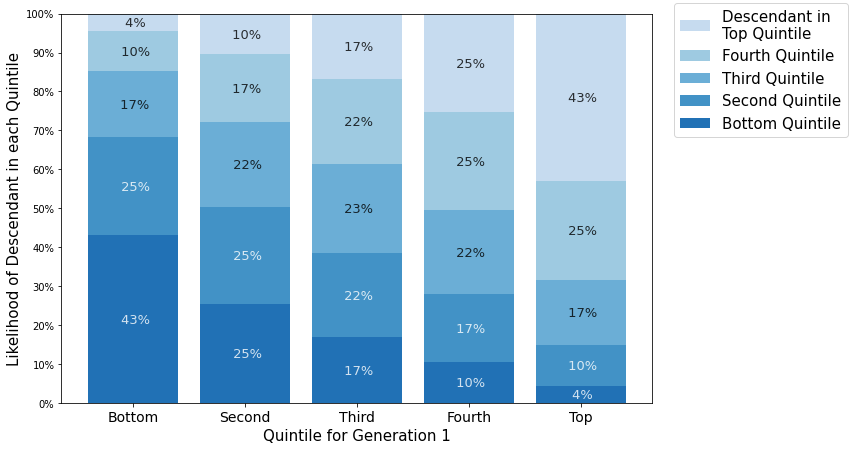

In [40]:
# Pearson female
matrix_pf = get_matrix(r=0.54, rs=0.96)

plot_matrix(matrix_pf, n=1)

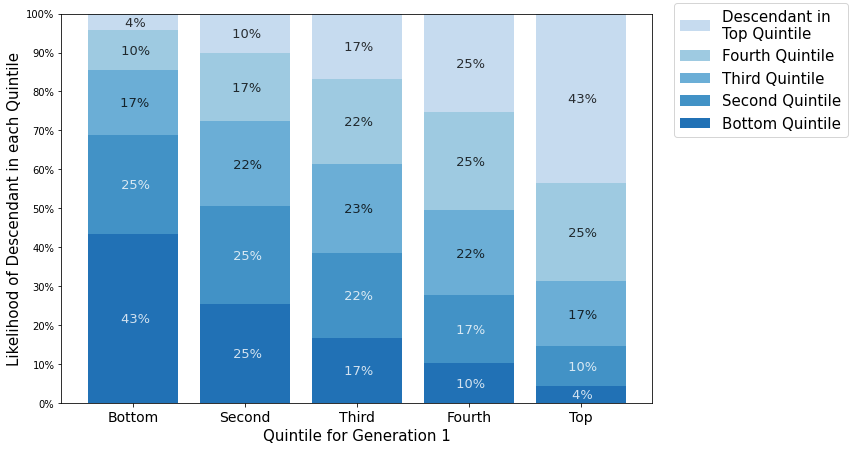

In [41]:
# Pearson male
matrix_pm = get_matrix(r=0.51, rs=0.89)

plot_matrix(matrix_pm, n=1)

In [42]:
# for r in np.arange(0.2, 0.9, 0.1):
    
#     plot_matrix(get_matrix(r=r, rs=stable_rs(r)))
#     plt.title(str(round(r, 2)) + ', ' + str(round(stable_rs(r), 2)) + ', ' + str(round(stable_rs(r) / r, 2)))
#     plt.show()

#### Theoretical, stable population

#### Quintile-quintile matrices

Number of calcuations = `25*num_iters*num_steps`. Because each entry in a quintile-quintile matrix has `num_iters` number of iterations.

In [74]:
r = 0.5
rs = stable_rs(r)

num_steps = 6

matrices = [None] * num_steps
print('r_s =', rs)
assert np.allclose(1, np.square(rs) + np.square(r))

r_s = 0.8660254037844386


In [75]:
%%time
for i in range(num_steps):
    matrices[i] = get_matrix(r=r, rs=rs, n=i+1, num_iters=500_000, low_round=6,
                            n_subs0=5, n_subs1=5)

CPU times: user 8.17 s, sys: 2.77 s, total: 10.9 s
Wall time: 11 s


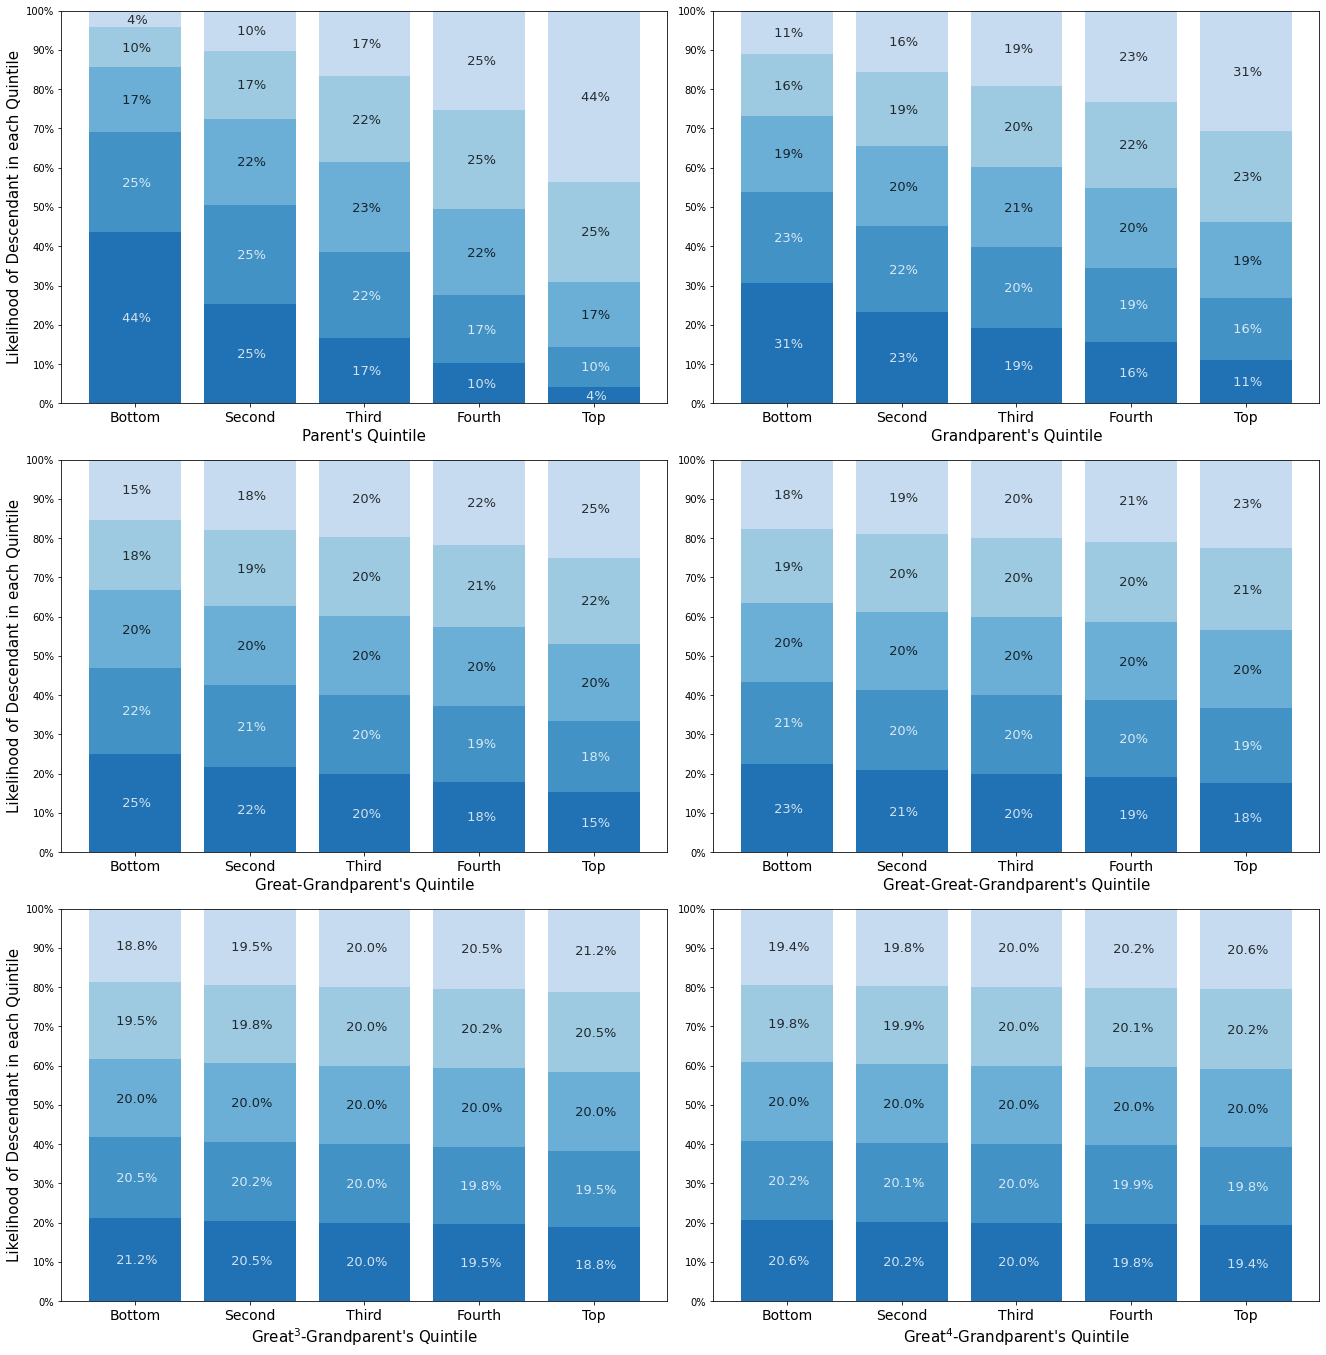

In [76]:
from matplotlib.ticker import PercentFormatter
fig, axes = plt.subplots(3, 2, figsize=(13*2*0.95*0.75, 8*3/0.95*0.75))
pal = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5']
legend = ['Descendant in\nTop Quintile', 'Fourth Quintile', 'Third Quintile', 'Second Quintile', 'Bottom Quintile']
pal.reverse()

for i in range(num_steps):
    plot_ax(ax=axes.ravel()[i], matrix=matrices[i], i=i)

# fig.legend(legend, loc="center right", fontsize=15)   
plt.tight_layout()
# plt.savefig('latex/figures/quintile-r=0.5-stable.png', dpi=350)
plt.show()